## Project: Bike counts on East River Bridges prediction using machine learning
- **Source**: Sachin Date, Statistical Modeling and Forecasting, 
- **URL**: https://data.cityofnewyork.us/Transportation/Bicycle-Counts-for-East-River-Bridges-Historical-/gua4-p9wg/about_data
- **Date**: 29/11/24
- **Goal**: Create a basic prediction model and a feature explainer

In [36]:
# Step 0. Load libraries and custom modules
# Basics ---------------------------------------------------------------
import os
import joblib
import logging
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
from patsy import dmatrices
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [37]:
# Step 1. Load data
# 1.1 Retrieve data from source and get basic info
url = (
    'https://gist.githubusercontent.com/sachinsdate/' + 
    'c17931a3f000492c1c42cf78bf4ce9fe/raw/' + 
    '7a5131d3f02575668b3c7e8c146b6a285acd2cd7/' + 
    'nyc_bb_bicyclist_counts.csv'
)
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      214 non-null    object 
 1   HIGH_T    214 non-null    float64
 2   LOW_T     214 non-null    float64
 3   PRECIP    214 non-null    float64
 4   BB_COUNT  214 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 8.5+ KB


In [38]:
# 1.2 Show a sample
df_raw.sample(10, random_state=2024)

,Date,HIGH_T,LOW_T,PRECIP,BB_COUNT
143,22-Aug-17,88.0,75.0,0.30,2983
78,18-Jun-17,84.0,72.0,0.01,2199
49,20-May-17,64.0,55.9,0.01,2161
33,4-May-17,63.0,50.0,0.00,3019
116,26-Jul-17,75.9,66.0,0.00,3821
171,19-Sep-17,78.1,69.1,0.22,2012
72,12-Jun-17,91.9,77.0,0.00,2854
117,27-Jul-17,77.0,66.9,0.01,3287
133,12-Aug-17,75.9,64.9,0.11,4146
92,2-Jul-17,87.1,73.0,0.00,2467


**Data dictionary**

|Variable Name|Role|Type|Description|Units|Missing Values|
|-------------|----|----|-----------|-----|--------------|
|date|index|datetime|Date of count|yyyy-mm-dd|no|
|high_t|feature|float|Highest temperature record|F|no|
|low_t|feature|float|Lowest temperature record|F|no|
|precip|feature|float|Precipitation registered|F|no|
|bb_count|target|integer|Bike count registered|F|no|

### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [39]:
# Step 2. Perform data preprocessing as expected by your data dictionary
# 2.1 Make the chain for transformations
df = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .drop_duplicates()
    .rename(columns={'bb_count':'target'})
    .astype({'date':'datetime64[ns]'})
    .assign(
        month = lambda x: x['date'].dt.month,
        day = lambda x: x['date'].dt.day,
        day_of_week = lambda x: x['date'].dt.dayofweek
    )
    .iloc[:, [4] + [c for c in range(8) if c!= 4]]
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   target       214 non-null    int64         
 1   date         214 non-null    datetime64[ns]
 2   high_t       214 non-null    float64       
 3   low_t        214 non-null    float64       
 4   precip       214 non-null    float64       
 5   month        214 non-null    int32         
 6   day          214 non-null    int32         
 7   day_of_week  214 non-null    int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1)
memory usage: 11.0 KB


In [40]:
# 2.2 Show final dataset
df

,target,date,high_t,low_t,precip,month,day,day_of_week
0,606,2017-04-01,46.0,37.0,0.00,4,1,5
1,2021,2017-04-02,62.1,41.0,0.00,4,2,6
2,2470,2017-04-03,63.0,50.0,0.03,4,3,0
3,723,2017-04-04,51.1,46.0,1.18,4,4,1
4,2807,2017-04-05,63.0,46.0,0.00,4,5,2
...,...,...,...,...,...,...,...,...
209,3150,2017-10-27,62.1,48.0,0.00,10,27,4
210,2245,2017-10-28,68.0,55.9,0.00,10,28,5
211,183,2017-10-29,64.9,61.0,3.03,10,29,6
212,1428,2017-10-30,55.0,46.0,0.25,10,30,0


### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [41]:
# 3.1 Create train and test splits
X = df.copy().drop('target', axis=1)
y = df['target'].copy()
horizon = 15
X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

In [42]:
# 3.2 Show descriptive statistics
display(df_train.describe(include='number').T)
display(df_train.describe(include='datetime').T)

,count,mean,std,min,25%,50%,75%,max
target,199.0,2692.824121,848.795114,151.0,2299.0,2860.0,3296.50,4960.00
high_t,199.0,74.775879,10.343935,46.0,66.9,75.9,82.90,93.90
low_t,199.0,62.593970,9.219000,37.0,55.9,64.9,70.00,78.10
precip,199.0,0.124925,0.351260,0.0,0.0,0.0,0.04,3.02
month,199.0,6.783920,1.893248,4.0,5.0,7.0,8.00,10.00
day,199.0,15.170854,8.792843,1.0,8.0,15.0,23.00,31.00
day_of_week,199.0,3.010050,2.017574,0.0,1.0,3.0,5.00,6.00


,count,mean,min,25%,50%,75%,max
date,199,2017-07-09 00:00:00,2017-04-01 00:00:00,2017-05-20 12:00:00,2017-07-09 00:00:00,2017-08-27 12:00:00,2017-10-16 00:00:00


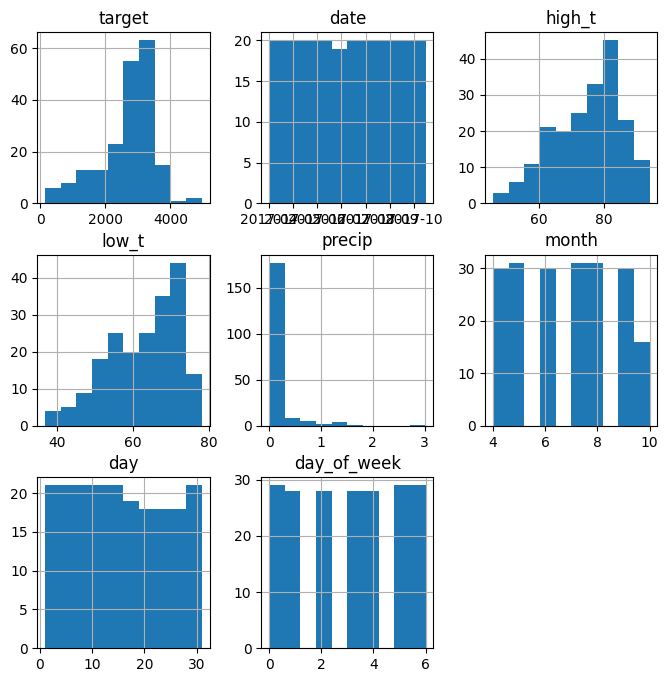

In [43]:
# 3.3 Display univariate analysis - Numeric 
df_train.hist(figsize=(8,8))
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [44]:
# Step 4. Create a machine learning model
# 4.1 Create GLM expression in patsy notation
expr = """target ~ day + day_of_week + month + high_t + low_t + precip"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [45]:
# 4.2 Fit the model
poisson_reg = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  199
Model:                            GLM   Df Residuals:                      192
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14163.
Date:                Fri, 06 Dec 2024   Deviance:                       26404.
Time:                        02:55:07   Pearson chi2:                 2.63e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0077      0.012    607.655      

In [48]:
# 4.3 Update the train dataset with the mu value
df_train_up = df_train.copy()
df_train_up['bb_lambda'] = poisson_reg.mu
df_train_up['aux_ols_dep'] = (
    df_train_up.apply(
        lambda x: ((x['target']-x['bb_lambda'])**2 -x['bb_lambda'])/x['bb_lambda'], 
        axis=1)
)

In [52]:
# 4.4 Create a new expression and fit the model to get lambda coefficient
expr_up = """aux_ols_dep ~ bb_lambda - 1"""
ols_reg_up = smf.ols(expr_up, df_train_up).fit()
print(ols_reg_up.params)

bb_lambda    0.038151
dtype: float64


In [ ]:
# 4.5 Create a negative binomial 

0.03815088634495583